In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

Load the datasets

In [22]:
fights_data = pd.read_csv('../datasets/fights_data.csv')
fighters_data = pd.read_csv('../datasets/fighters_data.csv')

UFC Stats have many early UFC fights and fighters data missing. Most of them were preprocessed during the ETL process with intuition. However, there are still many missing values that could not be preprocessed for the sake of keeping a data accurate. It is a good practice to make sure where these datas are.

In [23]:
fighters_data.isna().sum()

name                    0
height_cm             304
weight_kg              86
reach_cm             1927
strikes_per_min         0
striking_accuracy       0
takedown_avg            0
takedown_accuracy       0
takedown_defense        0
submission_avg          0
dtype: int64

Looks like there are a significant amount of reach data missing, and some height and weight. Thankfully, we do not need any of these three categorical variables for our model...yet. Next, let us check the other dataset.

In [24]:
fights_data.isna().sum()

event_name             0
fighter_1              0
fighter_2              0
winner               145
method                 0
fighter_1_kd           0
fighter_1_sig_str      0
f1_sig_head            0
f1_sig_body            0
f1_sig_leg             0
f1_sig_distance        0
f1_sig_clinch          0
f1_sig_ground          0
fighter_1_td           0
fighter_1_sub_att      0
fighter_1_rev          0
fighter_1_ctrl         0
fighter_2_kd           0
fighter_2_sig_str      0
f2_sig_head            0
f2_sig_body            0
f2_sig_leg             0
f2_sig_distance        0
f2_sig_clinch          0
f2_sig_ground          0
fighter_2_td           0
fighter_2_sub_att      0
fighter_2_rev          0
fighter_2_ctrl         0
round_num              0
time                   0
dtype: int64

Uh oh, some winners are missing! Acually, there are some UFC matches that turn out to have been draw or No Contest. These are a very rare occurence in UFC. So it is alright for now. These matches would not help the model significantly anyway. Now let us get to analyzing.

## Fighter Stats mean, median and skewness

I want to have a superficial overlook at the fighter stats first.

In [25]:
# Columns to visualize
selected_columns = ['striking_accuracy', 'takedown_avg', 'takedown_accuracy', 'takedown_defense', 'submission_avg']

# Show mean, median and skewness
print(f"{'Feature':<20}{'Mean':>10}{'Median':>10}{'Skewness':>12}")
print("-" * 52)

for column in selected_columns:
    col_mean = fighters_data[column].mean()
    col_median = fighters_data[column].median()
    col_skewness = skew(fighters_data[column].dropna())
    
    print(f"{column:<20}{col_mean:>10.2f}{col_median:>10.2f}{col_skewness:>12.2f}")

Feature                   Mean    Median    Skewness
----------------------------------------------------
striking_accuracy         0.36      0.41       -0.53
takedown_avg              3.18      2.99        4.08
takedown_accuracy         0.26      0.23        0.91
takedown_defense          0.40      0.44        0.12
submission_avg            0.59      0.00        6.81


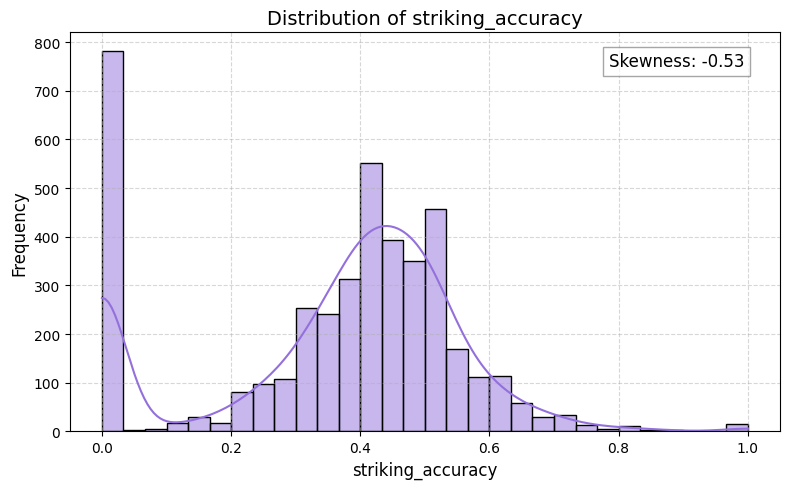

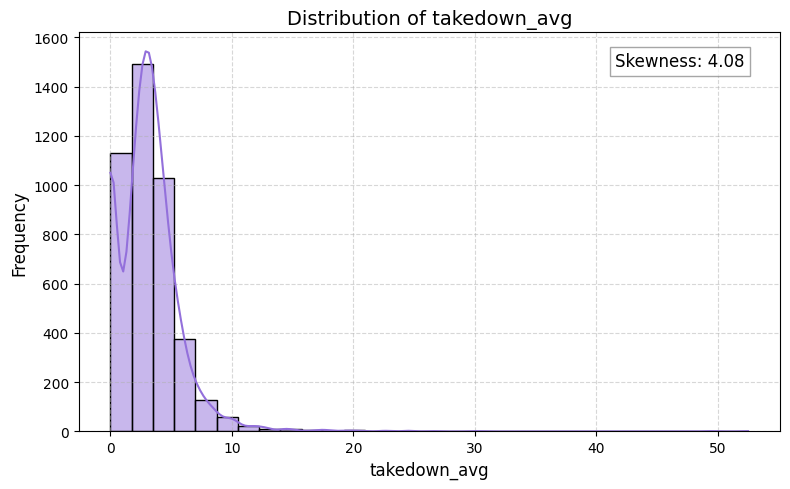

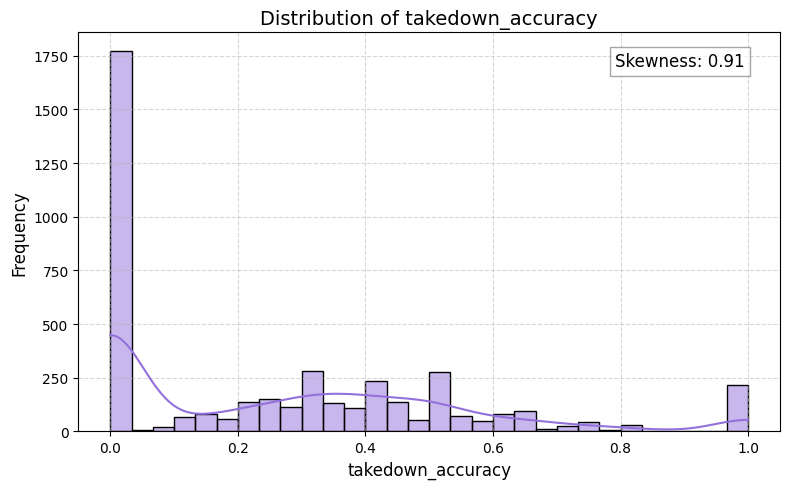

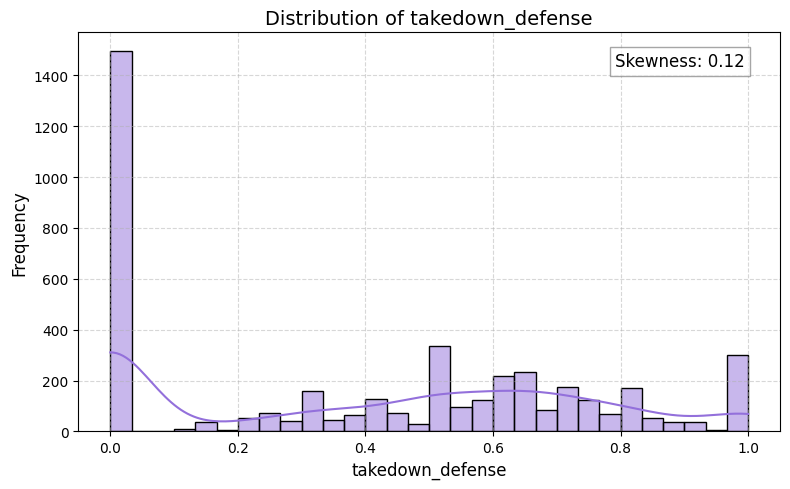

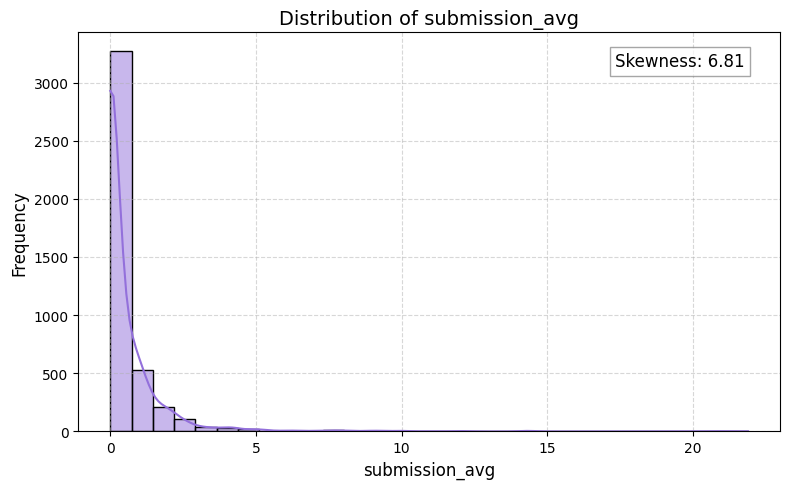

In [26]:
# Plot normal distribution with skewness
for column in selected_columns:
    data = fighters_data[column].dropna()
    col_skewness = skew(data)
    
    plt.figure(figsize=(8, 5))
    sns.histplot(data, kde=True, color='mediumpurple', bins=30)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Annotate skewness value
    plt.text(0.95, 0.95, f"Skewness: {col_skewness:.2f}", 
             ha='right', va='top', transform=plt.gca().transAxes,
             fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Looks like Takedown Defense is the only stat closest to being symmetrical. That means most fighters defend takedowns around the same rate. All the other stats have some outlier fighters skewing the average. Striking Accuracy is the only one with a negative skew, that means most fighters have good striking accuracy but some have bad accuracy that is pulling the average down. The strongest skew is the Submission average. Most fighters have no submissions, but a few have such a high number of subs that the average is skewed significantly! A similar picture is painted with the takedown average. The average takedown accuracy is also low. From these data it can be said:

1. **Most fighters focus on or have focused on striking more rather than grappling/wrestling**
2. **Fighters would rather polish on takedown defense rather than initiate takedowns**

But why? These decisions must be result driven. Let's find out.

## Fights Analysis: Striking vs Takedowns

Let's take a look at all the fights data. The idea is to see how many fighters had better significant strikes than takedowns and won, vice versa and how many winners had both those stats in their favor.

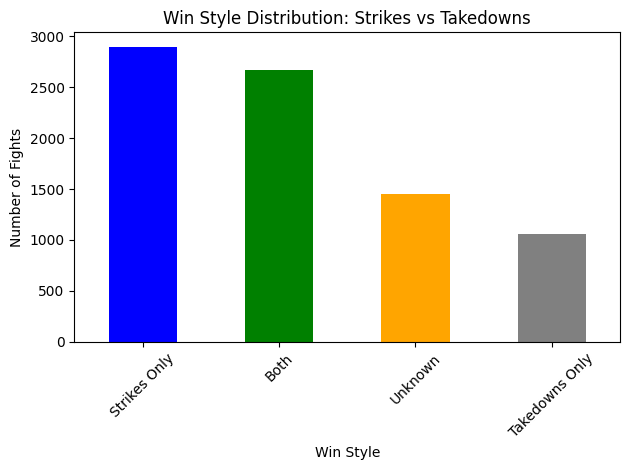

In [27]:
def determine_win_style(row):
    winner = row['winner']
    if winner == row['fighter_1']:
        sig_str_winner = row['fighter_1_sig_str']
        sig_str_loser = row['fighter_2_sig_str']
        td_winner = row.get('fighter_1_td', 0)
        td_loser = row.get('fighter_2_td', 0)
    elif winner == row['fighter_2']:
        sig_str_winner = row['fighter_2_sig_str']
        sig_str_loser = row['fighter_1_sig_str']
        td_winner = row.get('fighter_2_td', 0)
        td_loser = row.get('fighter_1_td', 0)
    else:
        # Fights that resulted in draw or no contest
        return 'Unknown'

# take the data of the winner
    sig_str_win = sig_str_winner > sig_str_loser
    td_win = td_winner > td_loser

    if sig_str_win and not td_win:
        return 'Strikes Only'
    elif td_win and not sig_str_win:
        return 'Takedowns Only'
    elif sig_str_win and td_win:
        return 'Both'
    else:
        return 'Unknown'

fights_data.dropna()
# Create a new column
fights_data['win_style'] = fights_data.apply(determine_win_style, axis=1)

# Count and display the results
win_style_counts = fights_data['win_style'].value_counts()

win_style_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'gray'])
plt.title('Win Style Distribution: Strikes vs Takedowns')
plt.xlabel('Win Style')
plt.ylabel('Number of Fights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Surprisingly, Strikes score more win than even a mixture.

## Correlation of other attributes to winning

How strong are the correlation matrices for each fighter's stats?

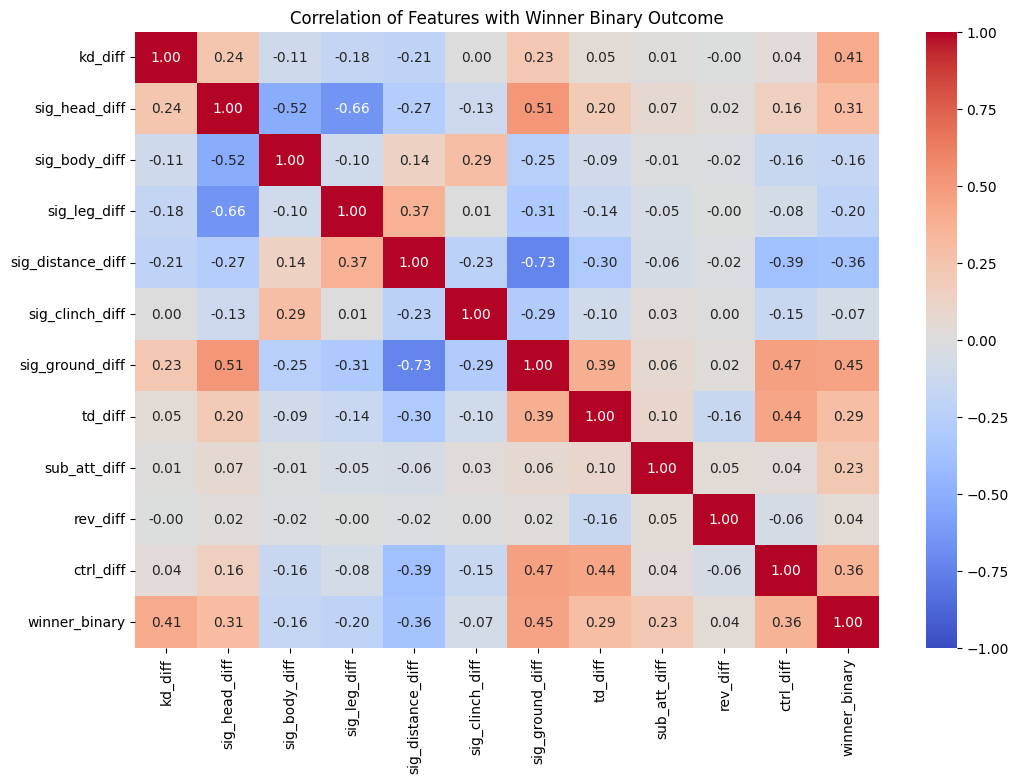

In [28]:
df = fights_data
# Create new columns for fighter statistics (differences between fighters)
df['kd_diff'] = df['fighter_1_kd'] - df['fighter_2_kd']
df['sig_head_diff'] = df['f1_sig_head'] - df['f2_sig_head']
df['sig_body_diff'] = df['f1_sig_body'] - df['f2_sig_body']
df['sig_leg_diff'] = df['f1_sig_leg'] - df['f2_sig_leg']
df['sig_distance_diff'] = df['f1_sig_distance'] - df['f2_sig_distance']
df['sig_clinch_diff'] = df['f1_sig_clinch'] - df['f2_sig_clinch']
df['sig_ground_diff'] = df['f1_sig_ground'] - df['f2_sig_ground']
df['td_diff'] = df['fighter_1_td'] - df['fighter_2_td']
df['sub_att_diff'] = df['fighter_1_sub_att'] - df['fighter_2_sub_att']
df['rev_diff'] = df['fighter_1_rev'] - df['fighter_2_rev']
df['ctrl_diff'] = df['fighter_1_ctrl'] - df['fighter_2_ctrl']

# Convert winner column to binary (1 for fighter_1 win, 0 for fighter_2 win, and 0.5 for draw)
winner_bin = []
for i in range(len(df['winner'])):
    if df['winner'][i] == df['fighter_1'][i]:
        winner_bin.append(1)
    elif df['winner'][i] == df['fighter_2'][i]:
        winner_bin.append(0)
    else:
        winner_bin.append(0.5)
        
df['winner_binary'] = winner_bin


# Select features for correlation analysis
features = ['kd_diff', 'sig_head_diff', 'sig_body_diff', 'sig_leg_diff', 'sig_distance_diff',
            'sig_clinch_diff', 'sig_ground_diff', 'td_diff', 'sub_att_diff', 'rev_diff', 'ctrl_diff']

# Calculate correlations between features and the binary winner
corr_matrix = df[features + ['winner_binary']].corr()



# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation of Features with Winner Binary Outcome')
plt.show()

Looks like none of them have a **strong** correlation. The strongest being Knockdown delta, which is to be expeccted (I mean duh). You can find out some interesting correlation of other stats to each other though. For example, there is a positive correlation with ground and head strikes (fighters have a easier and more likely chance of sig striking head while on the ground).